3DDiff file using Monterey and Eel canyons' profiles
================================================================

Set values of diffusivity within canyon using the no-canyon grid and the mean diffusivity profiles of Monterey and Eel canyons (/ocean/kramosu/Data/Diffusivity_profiles_Eel_and_Monterey.ipynb).

Files are:

* /ocean/kramosmu/Data/mean_kp_Monterey.csv 
* /ocean/kramosmu/Data/mean_kp_Eel.csv




In [8]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import struct

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import canyon_tools.readout_tools as rout

In [3]:
#Input 
nx = 616
ny = 360
nz = 90

kv_bg = 1E-5
kv_can = 1E-2

filename = "%dx%dx%d/KrDiff_Mty_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

In [32]:
## Get grid variables
fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)

Y = GridOut.variables['Y']
RC = GridOut.variables['RC']
X = GridOut.variables['X']

# Isolate canyon
delta = depth_Can-depth_NoC
delta_masked = np.ma.masked_less_equal(delta, 0.1) # 0.1 m difference gives a reasonable rim but I chose it arbitrarilly
    
np.shape(delta)

(360, 616)

Text(0,0.5,'km')

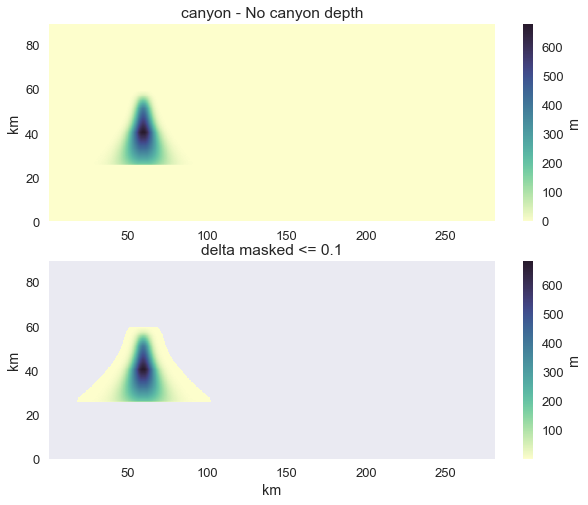

In [31]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
mesh = ax1.pcolor(X[:]/1000,Y[:]/1000, delta, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label('m')
ax1.set_title('canyon - No canyon depth')
ax1.set_ylabel('km')

mesh = ax2.pcolor(X[:]/1000,Y[:]/1000, delta_masked, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label('m')
ax2.set_title('delta masked <= 0.1')
ax2.set_xlabel('km')
ax2.set_ylabel('km')

In [33]:
# Build 3D array of diffusivities


In [7]:
# saving binary files



In [34]:
# Check that the values of the file are in the right order 

